-----

# word tokenize
- 使用 nltk, pattern 或 textblob 做 word tokenize。這邊統一使用 nltk 的 wordpunct_tokenize 切字。
- 資料取原始檔案的前 50000 行

# 計算 skip bigram 

- $p_j^i$ 
- ngram 任何位置不包含符號
- skip bigram 不包含 stop words 與數字

In [2]:
from __future__ import division

k0 = 1
k1 = 1
U0 = 10
max_distance = 5

In [1]:
# 示範 code ，修改下列 code 達到目的
# 可跳過 ngram ，直接計算 skip bigram
from nltk.tokenize import  wordpunct_tokenize 
from nltk.corpus import stopwords 

eng_stopwords = set(stopwords.words('english'))
eng_symbols = '{}"\'()[].,:;+!?-*/&|<>=~$'

def ngram_is_valid(ngram):
    first, last = ngram[0], ngram[-1]
    if first in eng_stopwords or last in eng_stopwords: return False
    if any( num in first or num in last for num in '0123456789'): return False
    if any( eng_symbol in word for word in ngram for eng_symbol in eng_symbols): return False
    return True

from collections import defaultdict, Counter
def to_ngrams( unigrams, length):
    return zip(*[unigrams[i:] for i in range(length)])  

ngram_counts = defaultdict(Counter)
with open('citeseerx_descriptions_sents.txt.50000') as text_file:
    for index,line in enumerate(text_file): 
        words = wordpunct_tokenize(line)
        for n in range(2, max_distance + 2):
            ngram_counts[n].update(filter(ngram_is_valid, to_ngrams(words, n)))
            
# print ngram_counts[5][('In',)]

IOError: [Errno 2] No such file or directory: 'citeseerx_descriptions_sents.txt.50000'

In [6]:
import pprint
skip_bigram_info = defaultdict(lambda: defaultdict(Counter))
for dist in range(2, max_distance + 2):
    for ngram, count in ngram_counts[dist].items():
        skip_bigram_info[ngram[0]][ngram[-1]] += Counter({dist-1: count})
        skip_bigram_info[ngram[-1]][ngram[0]] += Counter({1-dist: count})
        
# skip_bigram_info['play']

defaultdict(collections.Counter,
            {'Acquaintances': Counter({-1: 1}),
             'Agent': Counter({-2: 1}),
             'C': Counter({-1: 1}),
             'CTLs': Counter({-1: 1}),
             'Domain': Counter({-3: 1}),
             'Elimination': Counter({-2: 1}),
             'Groups': Counter({-3: 1}),
             'In': Counter({-5: 1}),
             'Inductors': Counter({-5: 1}),
             'Integral': Counter({-3: 1}),
             'Interconnect': Counter({-2: 1}),
             'Interest': Counter({-4: 1, -2: 2}),
             'Internet': Counter({-2: 1}),
             'Introduction': Counter({-4: 1}),
             'Large': Counter({-3: 1}),
             'MDA': Counter({5: 1}),
             'Mesh': Counter({-3: 1}),
             'Motivation': Counter({-3: 1}),
             'Multi': Counter({5: 1}),
             'Normal': Counter({-2: 1}),
             'Ontologies': Counter({-2: 1}),
             'R': Counter({-2: 1}),
             'RMP': Counter({-3: 1}),
     

### 階段檢查資料


In [7]:
skip_bigram_info['play'].items()[:10]
# skip_bigram_info['play']

[('xed', Counter({-5: 1})),
 ('What', Counter({-5: 1})),
 ('Interconnect', Counter({-2: 1})),
 ('help', Counter({3: 1})),
 ('produces', Counter({1: 1})),
 ('moments', Counter({-1: 1, 2: 1})),
 ('meetings', Counter({-2: 1})),
 ('automated', Counter({5: 1})),
 ('major', Counter({-3: 1, 2: 2})),
 ('sources', Counter({-4: 1}))]

In [6]:
skip_bigram_info['play']['role']

Counter({-5: 1, -4: 2, -2: 2, 2: 8, 3: 51, 4: 5, 5: 1})

# 計算 skip bigram 的各種統計資訊 
$freq,\ \bar{f},\ \sigma,\ u_i,\ \bar{p_i}$

In [7]:
from itertools import groupby
import numpy as np
skip_bigram_abc = defaultdict(lambda: 0)
for word, vals in skip_bigram_info.items():
    count = []
    for coll, val in vals.items():
        c = val.values()
        c_bar = sum(c) / (2*max_distance)
        skip_bigram_abc[(word, coll, 'freq')] = sum(c)
        skip_bigram_abc[(word, coll, 'spread')] = (sum([x**2 for x in c]) - 2*c_bar*sum(c) + 2*max_distance*c_bar**2) / (2 * max_distance)
        count.append(sum(c))
    skip_bigram_abc[(word, 'avg_freq')] = np.mean(count)
    skip_bigram_abc[(word, 'dev')] = np.std(count)

### 階段檢查資料
- $\bar{f}$ : `avg_freq`
- $\sigma$ : `dev`
- $u_i$ : `spread`
- $freq$ : `freq`


In [8]:
# print skip_bigram_info['difficulty']
print skip_bigram_info["play"]["role"]
print skip_bigram_abc[('play','avg_freq')]
print skip_bigram_abc[('play','dev')]
print skip_bigram_abc[('play','role','spread')]
print skip_bigram_abc[('play','role','freq')]

Counter({3: 51, 2: 8, 4: 5, -4: 2, -2: 2, 5: 1, -5: 1})
1.52475247525
4.1971089989
221.0
70


## 使用 pandas 畫出 play role 的各距離數量 

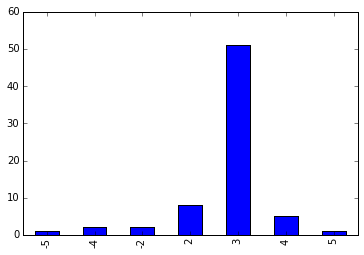

In [9]:
import pandas 
%matplotlib inline
play_role_distances_count = pandas.Series(skip_bigram_info['play']['role'].values(), index= skip_bigram_info['play']['role'].keys()).sort_index()
play_role_distances_count.plot(kind='bar')

# 依據 Smadja’s 三個規則篩選 skip bigrams

$$\begin{cases} 
strength = \frac{freq - \bar{f}}{\sigma} \ge k_0 & (C_1)\\
spread \ge u_0 & (C_2) \\
p_j^i \ge \bar{p_i} + (k_1 \times \sqrt{u_i}) & (C_3) 
\end{cases}$$

In [13]:
import math
def skip_bigram_filter(skip_bigram_info, skip_bigram_abc):
    cc = []
    for word, vals in skip_bigram_info.items():
        f = skip_bigram_abc[(word, 'avg_freq')]
        for coll, val in vals.items():
            if skip_bigram_abc[(word, 'dev')]-0 < 1E-6:
                strength = 0
            else:
                strength = (skip_bigram_abc[(word, coll, 'freq')] - f) / skip_bigram_abc[(word, 'dev')]
            if strength < k0:
                continue
            spread = skip_bigram_abc[(word, coll, 'spread')]
            if spread < U0:
                continue
            c_bar = sum(val.values()) / (2*max_distance)
            peak = c_bar + k1 * math.sqrt(spread)
            for dist, count in val.items():
                if count >= peak:
                    cc.append((word, coll, dist, strength, spread, peak, count))
    return cc

cc = skip_bigram_filter(skip_bigram_info, skip_bigram_abc)

## 使用 pandas Dataframe 整理與顯示資料

In [14]:
# cc = [('base word', 'collocate', 'distance', 'strength', 'spread', 'peak', 'p').......]
import pandas
collocations_df = pandas.DataFrame(cc,
                                   columns = ['base word', 'collocate', 'distance', 'strength', 'spread', 'peak', 'p'])
collocations_df = collocations_df.set_index(['base word', 'collocate', 'distance']).sort_index()

### 列出 collocation Dataframe

In [15]:
collocations_df

strength    spread        peak    p
base word collocate distance                                      
#         #         -2        37.990803    506.56   87.706888  107
                     2        37.990803    506.56   87.706888  107
          The       -3         2.035968     13.16    7.427671   10
                    -2         2.035968     13.16    7.427671    8
          We        -5         1.333268     20.04    7.076606    8
                    -4         1.333268     20.04    7.076606   14
          c          1         2.153085    114.20   14.686440   36
          ciency     1         2.738668    178.60   18.364131   45
          cient      1         8.828738   2043.44   60.604425  151
          ciently    1         2.153085    128.60   15.340194   38
          coe       -1         1.216151     43.04    8.960488   22
          cult       1         1.860293    103.45   13.671037   34
          di        -1        20.716086   9893.61  135.166628  334
          e         -1        24.053912  11877.84  150.385504  368
          ect        1         2.035968    115.36   14.540577   36
          ective     1         3.148577    270.21   22.138066   55
          ectively   1         1.157593     47.61    9.200000   23
          ects       1         1.977410    109.21   14.150359   35
          er         1         1.860293     96.85   13.341240   33
          erent      1        12.459357   3617.24   81.743495  202
          erential   1         1.450384     59.96   10.543384   26
          ers        1         1.450384     59.96   10.543384   26
          n         -1         2.504435     24.44    9.543683   16
                     1         2.504435     24.44    9.543683   12
          o         -1         4.026952    384.56   26.810201   66
          su        -1         2.855785    223.16   20.138541   50
          tra       -1         1.743176     85.61   12.552567   31
          two       -2         1.801735     15.84    7.379950   13
                     3         1.801735     15.84    7.379950    8
          usion      1         1.099034     43.56    8.800000   22
...                                 ...       ...         ...  ...
work      done       1         4.073897     15.44    6.529377    8
                     3         4.073897     15.44    6.529377   11
          earlier   -1         2.350643     17.24    5.752108   14
          future    -1         4.246222     41.81    9.166065   22
          main      -4         2.005992     12.64    4.955278   12
          paper     -4         6.486453     28.20    9.310367   13
                    -3         6.486453     28.20    9.310367   15
          present   -2         4.418548     11.56    6.200000    7
                    -1         4.418548     11.56    6.200000   11
          previous  -1        13.551795    469.09   29.758486   73
          progress   2         2.005992     12.64    4.955278   12
          recent    -1         4.246222     60.41   10.472387   26
          well       1         1.833666     10.61    4.557299   11
works     previous  -1         9.569996     14.84    5.452272   13
world     data       1         5.345151     12.21    5.194281   12
          real      -1        22.807470    390.81   26.468915   66
          virtual   -1         3.948165     10.61    4.557299   11
worst     case       1        11.213565     43.21    8.873431   22
would     allow      1         6.998167     10.76    4.480244   11
          like       1        14.299831     31.81    7.940035   19
x         #         -1        10.066947     52.41   11.939475   12
                     1        10.066947     52.41   11.939475   24
years     In        -2         8.225192     84.60   13.197826   31
          ago        1         1.962656     10.89    4.400000   11
          last      -2         8.009242     73.29   12.460958   28
          many      -1         3.042404     20.04    6.076606   15
          past      -2         8.441141    107.49   14.467738   35
          r

### 依據 strength 排序 collocation

In [159]:
collocations_df.sort_values(by = 'strength', ascending=False)[:10]

strength     spread        peak     p
base word collocate distance                                        
This      paper      1        48.541987  342586.69  782.409055  1953
also      We        -1        43.152065   13829.36  159.398299   394
In        paper      2        39.973864  288595.41  720.910769  1795
#         #          2        37.990803     506.56   87.706888   107
                    -2        37.990803     506.56   87.706888   107
present   We        -1        37.248306   43512.69  284.696956   700
order     In        -1        36.934238    3010.44   73.267477   183
show      We        -1        36.319055   13484.29  167.221876   388
paper     This      -1        35.956122  342586.69  782.409055  1953
The       paper      1        35.098383    7977.44  138.716516   295

### collocation Dataframe 的各欄位統計數據

In [160]:
collocations_df.describe()

,strength,spread,peak,p
count,5586.000000,5586.000000,5586.000000,5586.000000
mean,7.707662,385.646523,11.889527,24.897601
std,5.059240,8558.524301,24.439706,60.029804
min,1.011534,10.000000,4.400000,5.000000
25%,3.875712,14.050000,5.800000,12.000000
50%,6.715695,23.040000,7.564878,15.000000
75%,10.315979,51.840000,11.200000,23.000000
max,48.541987,342586.690000,782.409055,1953.000000


### role 的相關 collocations

In [166]:
collocations_df.loc['difficulty']

KeyError: 'the label [difficulty] is not in the [index]'

### strength 的數據分佈

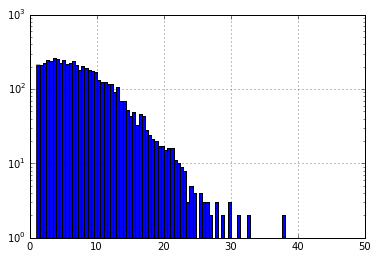

In [162]:
collocations_df.strength.hist(bins=100, log=True)

### 複雜篩選處理示範

In [164]:
collocations_df[ collocations_df.index.map(lambda x: x[2] == 1) & (collocations_df.spread > 800)  & (collocations_df.peak > 1000)
                ].sort_values(by = 'strength', ascending=False)[:20]

,,,strength,spread,peak,p
base word,collocate,distance,,,,
